In [1]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import os

# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=8, out_features=256, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=256, out_features=64, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=64, out_features=16, bias=True),
                                  nn.Dropout(0.5),
                                  nn.ReLU()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=16, out_features=1, bias=True),
                                        nn.ReLU())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=MLP().to(device)

In [2]:
#   average

import collections
fl_model=model
# # print(fl_model.state_dict())
# teachers_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/MLP_DP_SGD_california/teacher{tea_num}/best.pth')  for  tea_num in  range(5)]
# worker_state_dict = [x.state_dict() for x in teachers_models]
# weight_keys = list(worker_state_dict[0].keys())
# fed_state_dict = collections.OrderedDict()
# for key in weight_keys:
#     key_sum = 0
#     for i in range(len(teachers_models)):
#         key_sum = key_sum + worker_state_dict[i][key]
#     fed_state_dict[key] = key_sum / len(teachers_models)
 
# fl_model.load_state_dict(fed_state_dict)
# print(fl_model)

In [3]:
housedata=fetch_california_housing()
train_x,train_y=housedata.data,housedata.target
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
print(train_x.shape,train_y.shape,max(train_y),min(train_y))
x=np.array(train_x)
target=np.array(train_y)
import torch
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm
# target

from torch.utils.data import TensorDataset, DataLoader
train_dataset=TensorDataset(torch.tensor(x,dtype=torch.float,device=device),
                                    torch.tensor(target,dtype=torch.float,device=device))
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)


(20640, 8) (20640,) 5.00001 0.14999


In [4]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(fl_model, strict=False)
errors[-5:]

[]

In [5]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()
optimizer = torch.optim.SGD(fl_model.parameters(), lr=3e-3)
fl_model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=fl_model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=400,
    target_epsilon=2,
    # target_epsilon=4,
    # target_epsilon=6,
    target_delta=1e-3,
    max_grad_norm=1.2,
)
print(f"Using sigma={optimizer.noise_multiplier} ")

Using sigma=5.09765625 


/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [6]:
loss_all=[]
epsilon_all=[]
delta=1e-3
loss_func = torch.nn.MSELoss()
minloss=float('inf')
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager
for epoch in range(400):
    fl_model.train()
    train_loss = 0
    train_num=0
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=128, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for data,target in memory_safe_data_loader:
            
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output =fl_model(data)
            loss = loss_func(output, target)
            # losses.append(loss.item())
            loss.backward()
            optimizer.step()
            train_loss+=loss.item() * data.size(0)
            train_num += data.size(0)
            loss_stu = train_loss/train_num
            if loss_stu< minloss:
                minloss = loss_stu
        epsilon = privacy_engine.get_epsilon(delta=delta)
        print(f'\t epoch:{epoch}\t',f"Loss: {loss_stu:.6f} ",f"(ε = {epsilon:.2f}, δ = {delta})")
        loss_all.append(loss_stu)
        epsilon_all.append(epsilon)

# 
california_e2_loss=np.array(loss_all)
# california_e4_loss=np.array(loss_all)
# california_e6_loss=np.array(loss_all)


np.save('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e2_loss.npy',california_e2_loss)   # 保存为.npy格式
# np.save('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e4_loss.npy',california_e4_loss)   # 保存为.npy格式
# np.save('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e6_loss.npy',california_e6_loss)   # 保存为.npy格式

/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


	 epoch:0	 Loss: 5.530319  (ε = 0.06, δ = 0.001)
	 epoch:1	 Loss: 5.458982  (ε = 0.09, δ = 0.001)
	 epoch:2	 Loss: 5.537386  (ε = 0.12, δ = 0.001)
	 epoch:3	 Loss: 5.449121  (ε = 0.14, δ = 0.001)
	 epoch:4	 Loss: 5.461851  (ε = 0.16, δ = 0.001)
	 epoch:5	 Loss: 5.599235  (ε = 0.17, δ = 0.001)
	 epoch:6	 Loss: 5.453977  (ε = 0.19, δ = 0.001)
	 epoch:7	 Loss: 5.416191  (ε = 0.20, δ = 0.001)
	 epoch:8	 Loss: 5.462944  (ε = 0.22, δ = 0.001)
	 epoch:9	 Loss: 5.351311  (ε = 0.23, δ = 0.001)
	 epoch:10	 Loss: 5.454293  (ε = 0.25, δ = 0.001)
	 epoch:11	 Loss: 5.265527  (ε = 0.26, δ = 0.001)
	 epoch:12	 Loss: 5.228526  (ε = 0.27, δ = 0.001)
	 epoch:13	 Loss: 5.184833  (ε = 0.28, δ = 0.001)
	 epoch:14	 Loss: 5.141690  (ε = 0.30, δ = 0.001)
	 epoch:15	 Loss: 5.060246  (ε = 0.31, δ = 0.001)
	 epoch:16	 Loss: 5.065052  (ε = 0.32, δ = 0.001)
	 epoch:17	 Loss: 4.857058  (ε = 0.33, δ = 0.001)
	 epoch:18	 Loss: 4.759026  (ε = 0.34, δ = 0.001)
	 epoch:19	 Loss: 4.623560  (ε = 0.35, δ = 0.001)
	 epoch:20

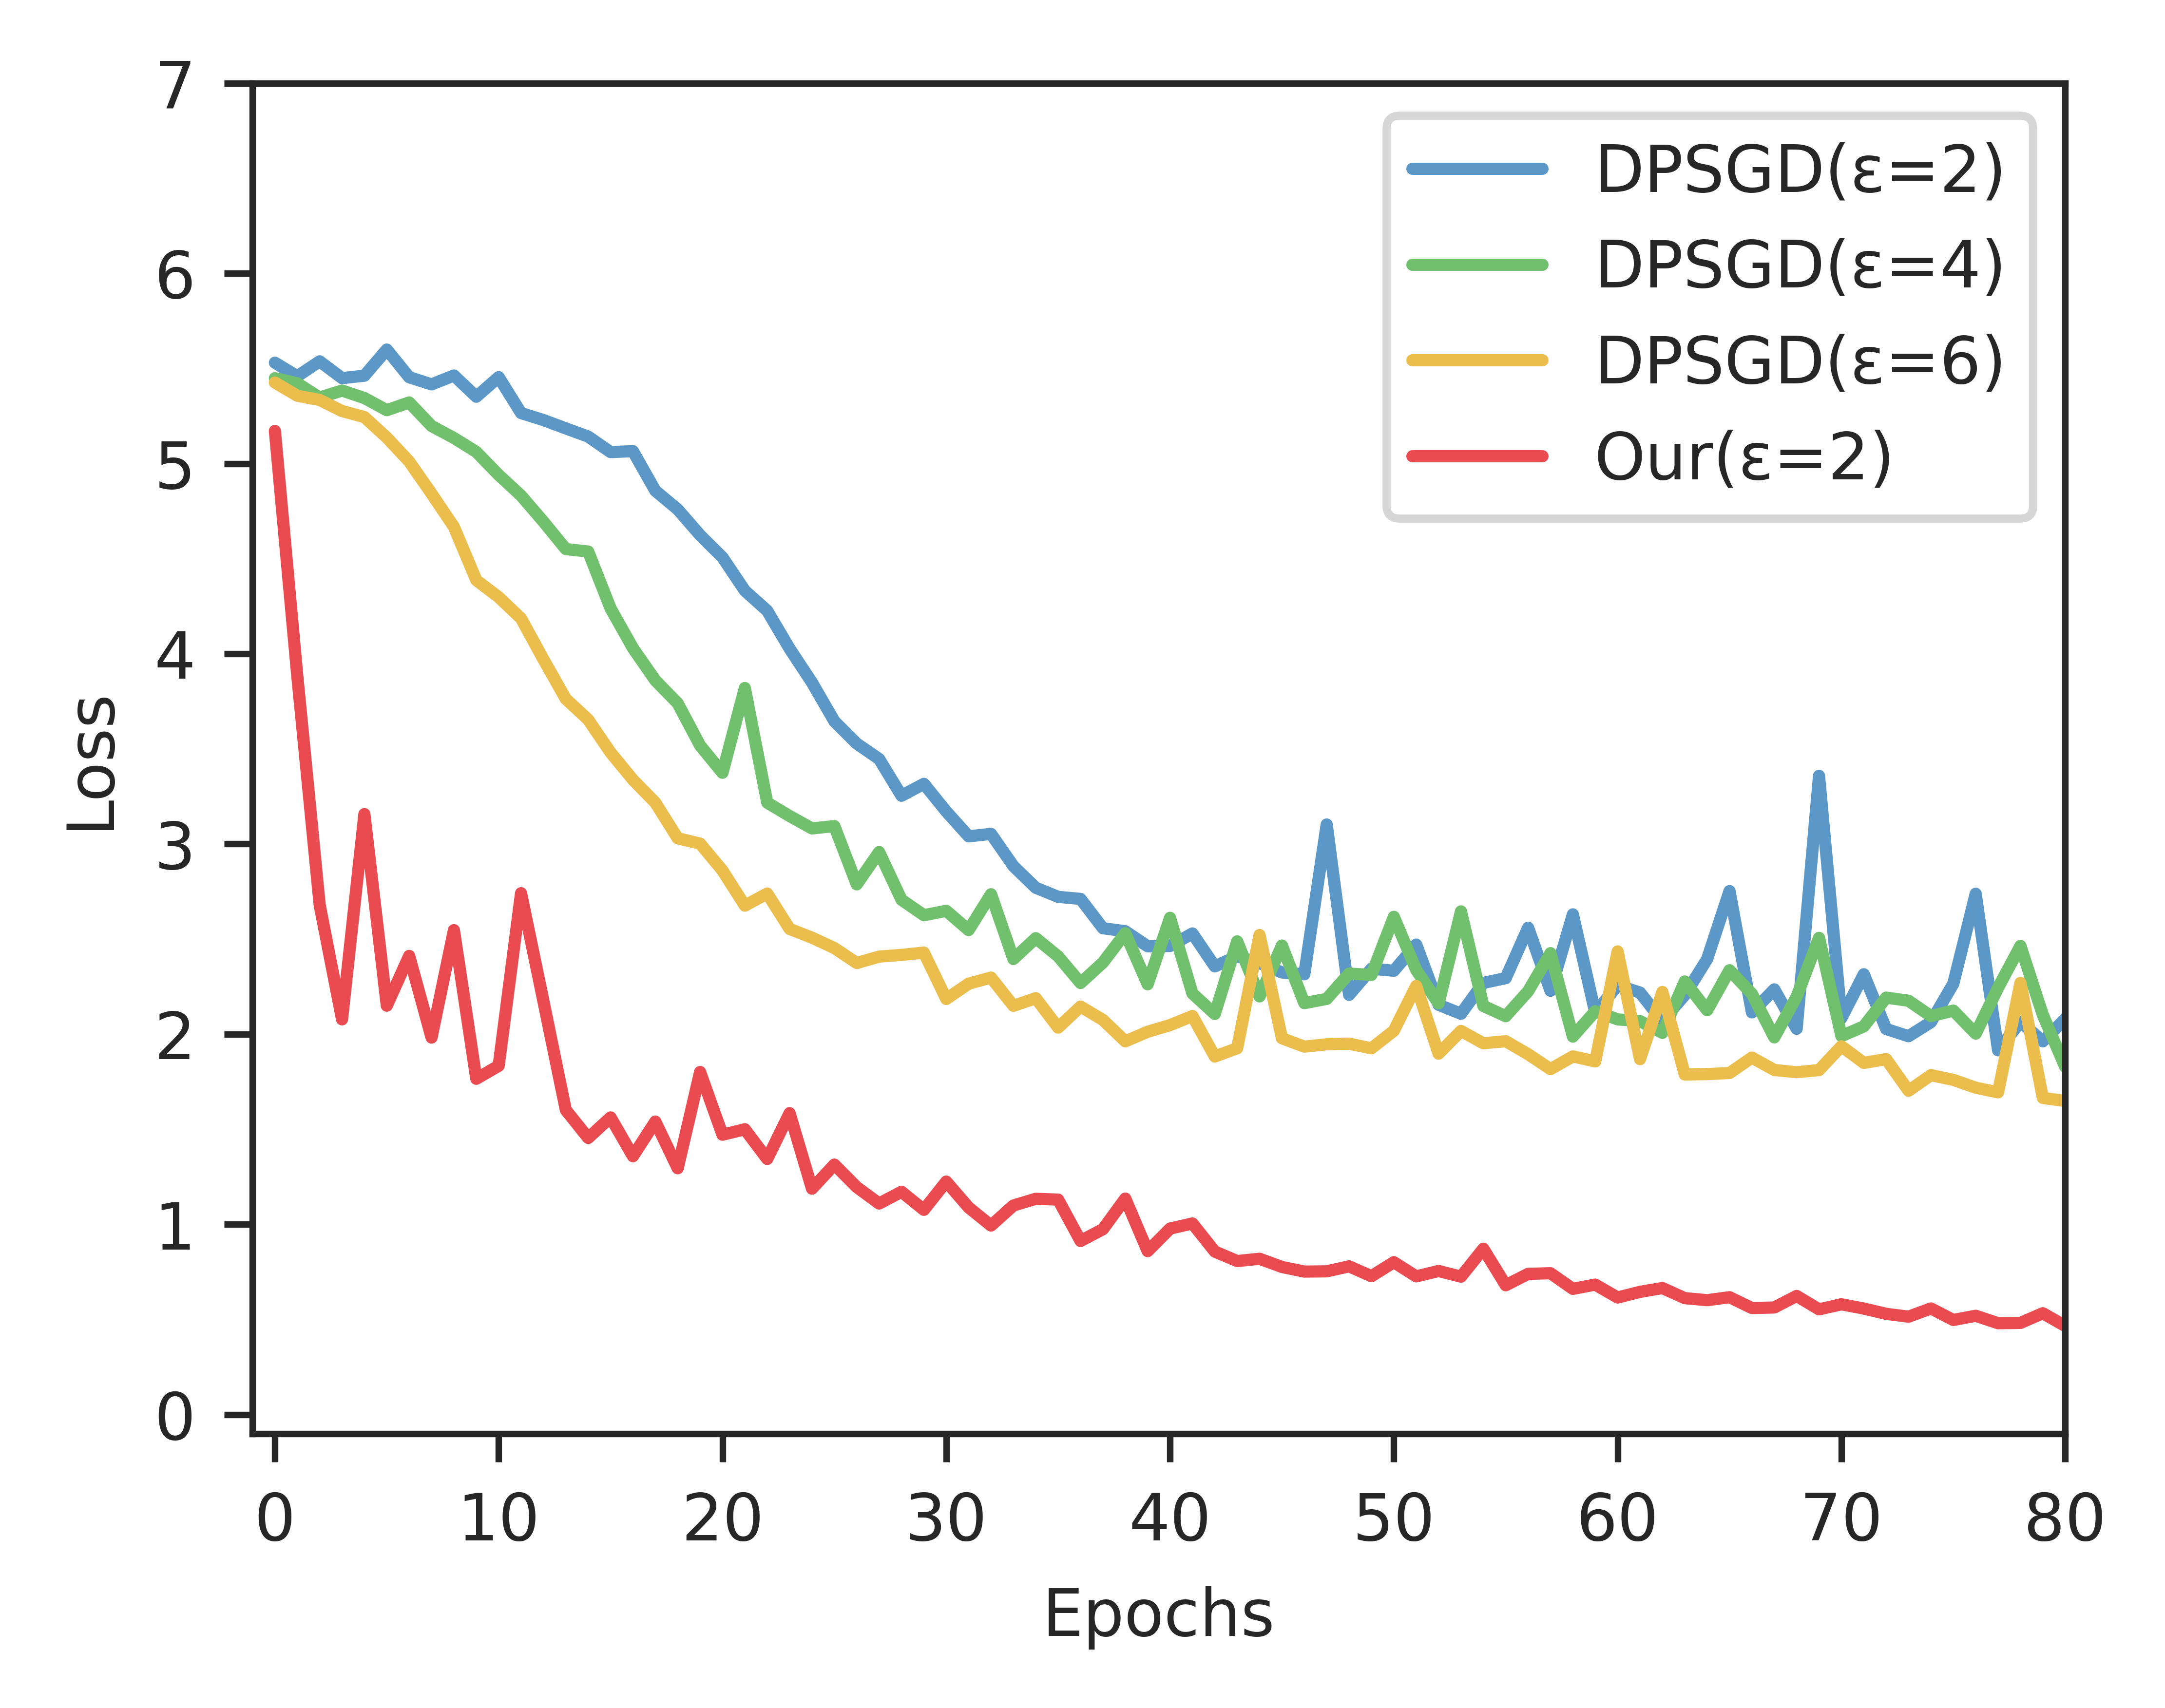

In [7]:
#svg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from  mpl_toolkits.axisartist import axis_artist

A=np.load('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e2_loss.npy')
B=np.load('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e4_loss.npy')
C=np.load('/home/ysy/ysy/Fed-ReKD/california_dpsgd_e6_loss.npy')
D=np.load('/home/ysy/ysy/Fed-ReKD/california_our_e2_loss.npy')

A=A.tolist()
B=B.tolist()
C=C.tolist()
D=D.tolist()


sns.set_style("ticks")
figure(num=None, figsize=(4, 3), dpi=1200)


plt.plot(A, '#5B97C7', label='DPSGD(ε=2)')
plt.plot(B, '#70C06D', label='DPSGD(ε=4)')
plt.plot(C, '#EBBD4D', label="DPSGD(ε=6)")
plt.plot(D, '#E94B51', label='Our(ε=2)')



plt.xticks(np.arange(0, 81, 10) , fontsize=8)
plt.yticks(np.arange(0, 7.1, 1),   fontsize=8)

plt.legend(loc='upper right', fontsize=8)


plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss',  fontsize=8)

plt.xlim(-1,80)
plt.ylim(-0.1,7)
plt.savefig('/home/ysy/ysy/Fed-ReKD/california_dpsgd.pdf', dpi=1200, bbox_inches="tight")
plt.show()

